# Inferring citation style from the reference string
Dominika Tkaczyk

16.11.2018

This notebook contains the experiments related to inferring citation style from the reference string. The main goal is to build a supervised classifier able to classify the given reference string into one of the known styles.

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from config import STYLES
from dataset import add_noise, clean_data, read_ref_strings_data, remove_technical_parts, rearrange_tokens, \
    generate_unknown
from evaluation import evaluate_cv
from features import get_features, get_tfidf_features, select_features_chi2, select_features_rf, tokens_to_classes
from random import randint, seed
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from statistics import mean

/home/dtkaczyk/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Preparing the data

### Reading the data

We are considering the following 17 styles in these experiments:

In [2]:
STYLES

['acm-sig-proceedings',
 'american-chemical-society',
 'american-chemical-society-with-titles',
 'american-institute-of-physics',
 'american-sociological-association',
 'apa',
 'bmc-bioinformatics',
 'chicago-author-date',
 'elsevier-without-titles',
 'elsevier-with-titles',
 'harvard3',
 'ieee',
 'iso690-author-date-en',
 'modern-language-association',
 'springer-basic-author-date',
 'springer-lecture-notes-in-computer-science',
 'vancouver']

The data for the experiments was generated automatically by formatting 5k metadata records (randomly chosen from the Crossref collection) into 17 styles. This resulted in 85k pairs (reference string, citation style name). We also keep the DOI of the metadata record used to generate the reference string.

In [3]:
dataset = read_ref_strings_data('../data/dataset/')
print('Dataset size: {}'.format(dataset.shape[0]))
dataset.head()

Dataset size: 85000


,doi,style,string
0,10.1016/s0002-9394(14)70125-4,acm-sig-proceedings,"[1]LEE, S.-H. and TSENG, S.C.G. 1997. Amniotic..."
1,10.1016/0920-9964(95)95073-i,acm-sig-proceedings,"[1]Scheffer, R. et al. 1995. History of premor..."
2,10.1075/cilt.97.22vek,acm-sig-proceedings,"[1]Vekerdi, J. 1993. 4. Word formation in Gips..."
3,10.1080/19761597.2013.810947,acm-sig-proceedings,"[1]Kang, J. et al. 2013. Determinants of succe..."
4,10.1016/0378-1119(79)90090-8,acm-sig-proceedings,"[1]Wickens, M.P. et al. 1979. Restriction map ..."


Let's see example entries for each style:

In [4]:
seed(10)
examples = dataset.groupby('style').nth(randint(0, 4999)).reset_index()
print('\n\n'.join(['{}\n{}'.format(s, t) for s, t in zip(examples['style'].tolist(), examples['string'].tolist())]))

acm-sig-proceedings
[1]Dorofeev, Y.G. et al. 1990. Effect of carbonyl iron powder additions on the properties of materials produced by dynamic hot pressing. Soviet Powder Metallurgy and Metal Ceramics. 29, 6 (Jun. 1990), 427–430.

american-chemical-society
(1) Dorofeev, Y. G.; Marinenko, L. G.; Ustimenko, V. I. Soviet Powder Metallurgy and Metal Ceramics 1990, 29, 427–430.

american-chemical-society-with-titles
(1) Dorofeev, Y. G.; Marinenko, L. G.; Ustimenko, V. I. Effect of Carbonyl Iron Powder Additions on the Properties of Materials Produced by Dynamic Hot Pressing. Soviet Powder Metallurgy and Metal Ceramics 1990, 29, 427–430.

american-institute-of-physics
1 Y.G. Dorofeev, L.G. Marinenko, and V.I. Ustimenko, Soviet Powder Metallurgy and Metal Ceramics 29, 427 (1990).

american-sociological-association
Dorofeev, Yu. G., L. G. Marinenko, and V. I. Ustimenko. 1990. “Effect of Carbonyl Iron Powder Additions on the Properties of Materials Produced by Dynamic Hot Pressing.” Soviet Powd

### Data cleaning

First, let's get rid of null and very short reference strings:

In [5]:
dataset = clean_data(dataset)
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 82834


We also have some remains from DOI stripping and other "technical" fragments in the strings. We will remove those parts.

In [6]:
seed(0)
dataset['string'] = dataset['string'].apply(remove_technical_parts)

Reference strings generated automatically are also a bit too perfect. For example, all strings of american-chemical-society style are prefixed by "(1)". This prefix alone would be enough for the learning algorithm to assign a string to this style. On the other hand, we cannot expect all strings "in real life" to have a proper prefix (some tools/extractors might strip this).

Also, the strings were generated from rich metadata records, and as a result, contain fragments such as the names of the months from the publication date. In practise, however, the dates are typically given as years only ("(1997)" instead of "(Mar 1997)").

To make the dataset a bit less perfect, let's remove such fragments from some of the references:

In [7]:
seed(10)
dataset['string'] = dataset['string'].apply(add_noise)
dataset.head()

,doi,style,string
0,10.1016/s0002-9394(14)70125-4,acm-sig-proceedings,"[1]LEE, S.-H. and TSENG, S.C.G. 1997. Amniotic..."
1,10.1016/0920-9964(95)95073-i,acm-sig-proceedings,"[1]Scheffer, R. et al. 1995. History of premor..."
2,10.1075/cilt.97.22vek,acm-sig-proceedings,"Vekerdi, J. 1993. 4. Word formation in Gipsy l..."
3,10.1080/19761597.2013.810947,acm-sig-proceedings,"Kang, J. et al. 2013. Determinants of successf..."
4,10.1016/0378-1119(79)90090-8,acm-sig-proceedings,"[1]Wickens, M.P. et al. 1979. Restriction map ..."


Finally, we will add the "unknown" category to the dataset. The reference strings in this category will be generated by randomly swapping tokens in the "proper" reference strings.

In [8]:
seed(0)
dataset_unknown = generate_unknown(dataset, 5000, random_state=0)
dataset = pd.concat([dataset, dataset_unknown])
print('Dataset size: {}'.format(dataset.shape[0]))

Dataset size: 87834


### Splitting the data

We will split the dataset randomly into training (75%) and test (25%) sets. The training set will be used to find the best learning algorithm and its meta-parameters. The test set will be used once to evaluate the final chosen model. This provides a fair, unbiased estimate of the model performance.

The data will be split based on DOIs, for better separation (i.e. all strings generated from a specific DOI will belong either to the train set or the test set).

In [9]:
train_doi, test_doi = train_test_split(dataset['doi'].drop_duplicates(), random_state=0)
train_dataset = dataset.loc[dataset['doi'].isin(train_doi)]
test_dataset = dataset.loc[dataset['doi'].isin(test_doi)]
print('Train dataset size: {}'.format(train_dataset.shape[0]))
print('Test dataset size: {}'.format(test_dataset.shape[0]))

Train dataset size: 65723
Test dataset size: 22111


## Feature representation

We will use a TF-IDF bag-of-ngrams representation of the reference strings. In this case, however, the tokens will be different from the typical use case. We will leave punctuation characters as tokens, and map the actual words into word classes such as "capitalized word", or "uppercase letter". This is done to preserve the style-related information. We will also mark the beginning and the end of the string with special tokens.

This function maps the tokens in the string into our token classes:

In [10]:
tokens_to_classes('Eberlein, T. J. Yearbook of Surgery 2006, 2006, 322–324.')

'start capword comma uclett dot uclett dot capword lcword capword year comma year comma num dash num dot end'

## The basic model

Let's now build some models and evaluate them. We will use logistic regression algorithm to predict the style from TF-IDFs of the tokens. We will use all {1,2}-grams we have in the train set. We will perform a 5-fold cross-validation on the train set, and look at the resulting accuracy.

Function *get_tfidf_features* passed to the evaluation function calculates a matrix of TD-IDF features for the list of strings. It is typically called twice, first on the training set and then on the test set (in this case, it will be called twice for every cross-validation split). When called on the training set, it calculates the vocabulary and IDFs using the entire training set (this is called fitting). When called on the test set, nothing is learned from the entire test set, but we reuse the vocabulary and IDFs calculated previously on the training set.

In [11]:
accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0), feature_fun=get_tfidf_features,
                            ngrams=(1, 2), nfeatures=None, feature_selector=None)
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9092652402099314, 0.9194568259562559, 0.9114349775784754, 0.9162230035158212, 0.9134663094174854]
Mean accuracy: 0.9139692713355938


The accuracy is already decent.

## Choosing the ngram range

Let's now see how the ngram range affects the accuracy:

In [12]:
results = np.zeros((4, 4))
for min_r in range(1, 5):
    for max_r in range(min_r, 5):
        accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0), feature_fun=get_tfidf_features,
                                    ngrams=(min_r, max_r))
        results[min_r-1, max_r-1] = mean(accuracies)
        print('Accuracy for ngrams range ({}, {}): {}'.format(min_r, max_r, mean(accuracies)))

Accuracy for ngrams range (1, 1): 0.6465053840737089
Accuracy for ngrams range (1, 2): 0.9139692713355938
Accuracy for ngrams range (1, 3): 0.9361278289261937
Accuracy for ngrams range (1, 4): 0.9404986946495688
Accuracy for ngrams range (2, 2): 0.9175321081510199
Accuracy for ngrams range (2, 3): 0.93820971684657
Accuracy for ngrams range (2, 4): 0.9413294390030559
Accuracy for ngrams range (3, 3): 0.9384542907874611
Accuracy for ngrams range (3, 4): 0.9403969245628565
Accuracy for ngrams range (4, 4): 0.9377062093109668


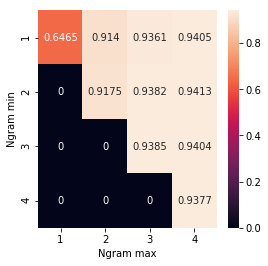

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(results, annot=True, fmt='.4g', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.ylabel('Ngram min')
plt.xlabel('Ngram max')
plt.show()

Based on this, we will choose the range (2, 4).
 
Let's calculate the features for our training set and look at the most frequent n-grams:

In [14]:
count_vectorizer, _, tfidf_features = get_tfidf_features(train_dataset['string'], ngrams=(2, 4))
tfidf_feature_names = count_vectorizer.get_feature_names()
print('Number of features: {}'.format(len(tfidf_feature_names)))

occurrences = count_vectorizer.fit_transform(train_dataset['string']).toarray().sum(axis=0)
indices = np.argsort(occurrences)[::-1]
tfidf_feature_names = np.array(tfidf_feature_names)[indices]
occurrences = np.array(occurrences)[indices]
print('\n'.join(['{}: {}'.format(p[0], p[1]) for p in list(zip(tfidf_feature_names, occurrences))[:50]]))

Number of features: 24003
capword capword: 195121
uclett dot: 149610
lcword lcword: 137573
capword comma: 123389
capword lcword: 117669
lcword capword: 107533
dot capword: 103985
lcword lcword lcword: 86536
comma uclett: 79855
capword lcword capword: 77304
comma uclett dot: 77278
comma capword: 67113
capword comma uclett: 66191
capword comma uclett dot: 65530
lcword lcword lcword lcword: 63551
capword capword capword: 59855
capword dot: 57203
lcword capword capword: 53550
uclett dot capword: 49408
capword capword lcword: 47698
num dash: 43068
dash num: 41990
dot uclett: 41811
capword lcword capword capword: 40863
dot uclett dot: 39392
num dash num: 39353
uclett dot uclett: 39180
uclett dot uclett dot: 38241
dot capword comma: 38191
capword capword lcword capword: 37662
uclett dot capword comma: 35189
lcword dot: 33134
comma num: 32692
dot end: 31597
start capword: 30403
num dot: 30352
capword capword dot: 29571
year rpar: 29383
num lpar: 29126
num comma: 28748
lpar year: 28319
lpar yea

We can see all types of ngrams. In most cases we can guess where they came from, eg. "lcword lcword lcword lcword" is typically a fragment of the title, and "uclett dot capword comma" looks like a fragment from the authors' list.

We can also check which features are the most correlated with the styles. We will use chi-squared statistic for this:

In [15]:
for style in STYLES:
    print()
    print('Style: {}'.format(style))
    features_chi2 = chi2(tfidf_features, train_dataset['style'] == style)[0]
    indices = np.argsort(features_chi2)
    feature_names = np.array(count_vectorizer.get_feature_names())[indices]
    bigrams = [v for v in feature_names if len(v.split(' '))  == 2]
    trigrams = [v for v in feature_names if len(v.split(' '))  == 3]
    fourgrams = [v for v in feature_names if len(v.split(' '))  == 4]
    print('Most correlated bigrams: {}'.format('|'.join(bigrams[-5:])))
    print('Most correlated trigrams: {}'.format('|'.join(trigrams[-5:])))
    print('Most correlated fourgrams: {}'.format('|'.join(fourgrams[-5:])))


Style: acm-sig-proceedings
Most correlated bigrams: dot lcword|dot year|rbracket year|rpar comma|rbracket capword
Most correlated trigrams: dot year rpar|num rbracket capword|rpar comma num|rbracket capword comma|year rpar comma
Most correlated fourgrams: num rbracket capword comma|dot year dot capword|rbracket capword comma uclett|lpar year rpar comma|year rpar comma num

Style: american-chemical-society
Most correlated bigrams: year comma|capword year|start lpar|semicolon capword|dot semicolon
Most correlated trigrams: start lpar num|comma num comma|semicolon capword comma|dot semicolon capword|uclett dot semicolon
Most correlated fourgrams: comma uclett dot semicolon|year comma num comma|dot semicolon capword comma|semicolon capword comma uclett|uclett dot semicolon capword

Style: american-chemical-society-with-titles
Most correlated bigrams: year comma|capword year|start lpar|semicolon capword|dot semicolon
Most correlated trigrams: start lpar num|comma num comma|semicolon capwor

## Feature selection

So far we used all n-grams present in the training set. Some of them are very rare and don't provide a lot of information for the training algorithm. Let's try using only n most frequent ngrams for different values of n, and see how it affects the accuracy.

In [16]:
nfeatures_results = []
nfeatures_values = range(100, 5100, 100)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0), feature_fun=get_tfidf_features,
                                nfeatures=n, ngrams=(2, 4))
    nfeatures_results.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 100 features: 0.8714592103362673
Accuracy for 200 features: 0.899295723284521
Accuracy for 300 features: 0.9132328055269486
Accuracy for 400 features: 0.9202133168611143
Accuracy for 500 features: 0.9235217854889272
Accuracy for 600 features: 0.9257211866436673
Accuracy for 700 features: 0.9277922960669052
Accuracy for 800 features: 0.9311097469991566
Accuracy for 900 features: 0.931776823909125
Accuracy for 1000 features: 0.9323640704650827
Accuracy for 1100 features: 0.9327465722049206
Accuracy for 1200 features: 0.934091375888872
Accuracy for 1300 features: 0.9351249959822796
Accuracy for 1400 features: 0.9356526669201841
Accuracy for 1500 features: 0.9362607187613203
Accuracy for 1600 features: 0.9364010306147609
Accuracy for 1700 features: 0.9372463657222844
Accuracy for 1800 features: 0.9377316860133652
Accuracy for 1900 features: 0.9381105098934152
Accuracy for 2000 features: 0.9383800824757019
Accuracy for 2100 features: 0.9385856143630013
Accuracy for 2200 feature

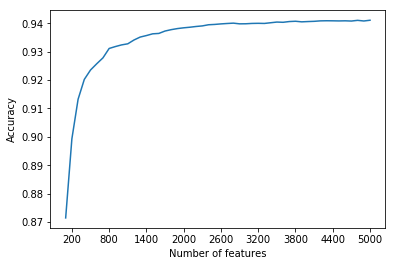

In [17]:
plt.plot(nfeatures_values, nfeatures_results)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

It seems that the more features we have the higher accuracy.

Choosing the most frequent features might not be optimal. Some frequent features will be useless because they don't provide any information about the target style. We can perform feature selection to choose a number of most useful features.

By passing *feature_selector* to the evaluation function we make sure the best features are selected in the training phase. In this case, the selection is done using feature importance scores from Random Forest.

Similarly as before, we will test this with varying number of chosen features:

In [18]:
nfeatures_results_rf = []
nfeatures_values = range(100, 5100, 100)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                                feature_fun=get_tfidf_features, feature_selector=select_features_rf,
                                nfeatures=n, ngrams=(2, 4))
    nfeatures_results_rf.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 100 features: 0.8287167385388481
Accuracy for 200 features: 0.8941625711248739
Accuracy for 300 features: 0.9099479743412275
Accuracy for 400 features: 0.921684968741279
Accuracy for 500 features: 0.92715564721287
Accuracy for 600 features: 0.9286958585579617
Accuracy for 700 features: 0.930492911381718
Accuracy for 800 features: 0.9309843545455188
Accuracy for 900 features: 0.9311046367663538
Accuracy for 1000 features: 0.9312874172375348
Accuracy for 1100 features: 0.9314329205068522
Accuracy for 1200 features: 0.9315725934437185
Accuracy for 1300 features: 0.9315867228734116
Accuracy for 1400 features: 0.9316290936774124
Accuracy for 1500 features: 0.9320996750998245
Accuracy for 1600 features: 0.9321765571366288
Accuracy for 1700 features: 0.9325635534347418
Accuracy for 1800 features: 0.9328268171474284
Accuracy for 1900 features: 0.932849384224936
Accuracy for 2000 features: 0.9326653533312479
Accuracy for 2100 features: 0.9326259618728904
Accuracy for 2200 features:

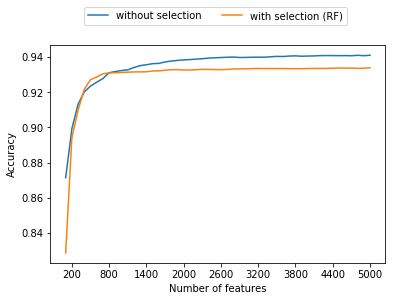

In [19]:
plt.plot(nfeatures_values, nfeatures_results)
plt.plot(nfeatures_values, nfeatures_results_rf)
plt.legend(['without selection', 'with selection (RF)'], bbox_to_anchor=(0.9, 1.2), ncol=3)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

We can see that in a small range RF selection results in slightly better performance, but as we increase the number of features, no selection outperforms RF-based selection.

We will also try a simpler selection method, based on chi-squared correlations:

In [20]:
nfeatures_results_chi2 = []
nfeatures_values = range(100, 5100, 100)
for n in nfeatures_values:
    accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                                feature_fun=get_tfidf_features, feature_selector=select_features_chi2,
                                nfeatures=n, ngrams=(2, 4))
    nfeatures_results_chi2.append(mean(accuracies))
    print('Accuracy for {} features: {}'.format(n, mean(accuracies)))

Accuracy for 100 features: 0.7984828408164626
Accuracy for 200 features: 0.8373753365858937
Accuracy for 300 features: 0.8674431041065864
Accuracy for 400 features: 0.8828535433916689
Accuracy for 500 features: 0.8899990633290411
Accuracy for 600 features: 0.9004321540293843
Accuracy for 700 features: 0.9216004639947383
Accuracy for 800 features: 0.9269758520984099
Accuracy for 900 features: 0.9295687247001928
Accuracy for 1000 features: 0.9335113525714204
Accuracy for 1100 features: 0.9343683763913921
Accuracy for 1200 features: 0.9353166244688512
Accuracy for 1300 features: 0.9359079868081511
Accuracy for 1400 features: 0.9368223047870962
Accuracy for 1500 features: 0.9368940304973354
Accuracy for 1600 features: 0.9377141292611081
Accuracy for 1700 features: 0.9379285492166397
Accuracy for 1800 features: 0.9380718683190293
Accuracy for 1900 features: 0.9382067125478616
Accuracy for 2000 features: 0.9385903955750471
Accuracy for 2100 features: 0.9387356530364886
Accuracy for 2200 feat

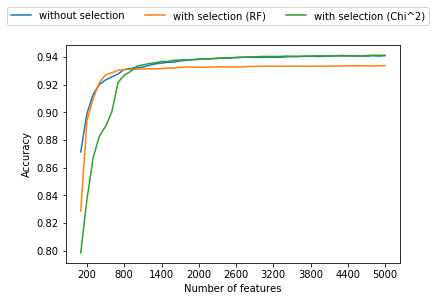

In [21]:
plt.plot(nfeatures_values, nfeatures_results)
plt.plot(nfeatures_values, nfeatures_results_rf)
plt.plot(nfeatures_values, nfeatures_results_chi2)
plt.legend(['without selection', 'with selection (RF)', 'with selection (Chi^2)'], bbox_to_anchor=(1.1, 1.2), ncol=3)
plt.xticks(list(range(200, 5100, 600)))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

The best accuracy was given by chi-squared selection with 5000 features. We will use that from now on.

## Final model

In [22]:
accuracies, _ = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                            feature_fun=get_tfidf_features, feature_selector=select_features_chi2,
                            nfeatures=5000, ngrams=(2, 4))
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9414614452967299, 0.9437130714211672, 0.9385446392172849, 0.9435459568056254, 0.939466110945718]
Mean accuracy: 0.9413462447373051


Let's also add one more feature (string length) to our feature representation.

In [23]:
accuracies, dataset_results_cv = evaluate_cv(train_dataset, LogisticRegression(random_state=0),
                                             feature_fun=get_features, feature_selector=select_features_chi2,
                                             nfeatures=5000, ngrams=(2, 4))
print('Fold accuracies: {}'.format(accuracies))
print('Mean accuracy: {}'.format(mean(accuracies)))

Fold accuracies: [0.9423698021800565, 0.9440240489271277, 0.9383408071748879, 0.9431441486690105, 0.9409546492011511]
Mean accuracy: 0.9417666912304468


Let's see the confusion matrix:

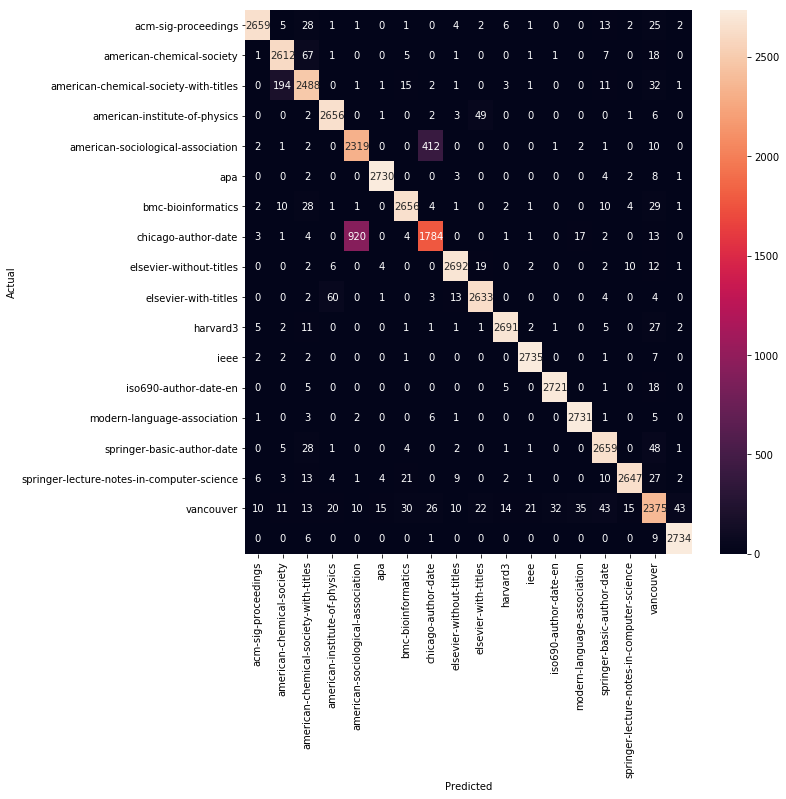

In [24]:
matrix = confusion_matrix(dataset_results_cv['style_true'], dataset_results_cv['style_pred'])

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=STYLES, yticklabels=STYLES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Everything looks pretty good apart from the pair (chicago-author-date, american-sociological-association), which seem to be confused a lot by the classifier.

This function will show the reference string pairs from the two given  styles for all DOI that were mislabelled.

In [25]:
def get_diff(actual, predicted):
    diff_df = dataset_results_cv.loc[dataset_results_cv['style_true'] == actual]
    diff_dois = diff_df.loc[diff_df['style_pred'] == predicted]['doi']
    diff_df = dataset_results_cv.loc[dataset_results_cv['doi'].isin(diff_dois)]
    diff_df = diff_df.loc[diff_df['style_true'].isin([actual, predicted])].sort_values(by='doi')
    strings = [re.sub('^\(1\)', '', re.sub('^\[1\]', '', re.sub('^1', '', re.sub('\.$', '', s)))).strip()
               for s in diff_df['string']]
    strings_0 = [s for i, s in enumerate(strings) if i%2 == 0]
    strings_1 = [s for i, s in enumerate(strings) if i%2 == 1]
    return list(zip(strings_0, strings_1))

In [26]:
get_diff('chicago-author-date', 'american-sociological-association')

[('Runne, Uee. 1977. “Cutaneous Neural Proliferation in Highly Pruritic Lesions of Chronic Prurigo.” Archives of Dermatology 113 (6) : 787',
  'Runne, Uee. 1977. “Cutaneous Neural Proliferation in Highly Pruritic Lesions of Chronic Prurigo.” Archives of Dermatology 113(6):787'),
 ('Silver, Bruce. 1979. “Double Contrast Gastrointestinal Radiology With Endoscopic Correlation.” JAMA: The Journal of the American Medical Association 242(17):1917',
  'Silver, Bruce. 1979. “Double Contrast Gastrointestinal Radiology With Endoscopic Correlation.” JAMA: The Journal of the American Medical Association 242 (17) : 1917'),
 ('Greenfield, Sheldon. 1992. “Specialists or Generalists? The Medical Outcomes Study-Reply.” JAMA: The Journal of the American Medical Association 268(12):1538',
  'Greenfield, Sheldon. 1992. “Specialists or Generalists? The Medical Outcomes Study-Reply.” JAMA: The Journal of the American Medical Association 268 (12) : 1538'),
 ('Kaiser, Harry M. 2003. “Distribution of Benefits 

In a lot of cases the reference strings are very similar, or identical. No wonder the classifier has problems differentiating between the styles.

Finally, let's test a few learning algorithms using previously chosen parameters:

In [27]:
algo_results = []
for name, algo in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(random_state=0)),
                   ('Linear SVC', LinearSVC(random_state=0)),
                   ('Random Forest', RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0))]:
    accuracies, _ = evaluate_cv(train_dataset, algo, feature_fun=get_features, feature_selector=select_features_chi2,
                                nfeatures=5000, ngrams=(2, 4))
    algo_results.extend([(name, fold, accuracy) for fold, accuracy in enumerate(accuracies)])
    print('Accuracy for {} algorithm {}'.format(name, mean(accuracies)))

Accuracy for Naive Bayes algorithm 0.9101841567371006
Accuracy for Logistic Regression algorithm 0.9417666912304468
Accuracy for Linear SVC algorithm 0.8650020934653031
Accuracy for Random Forest algorithm 0.8382677317812817


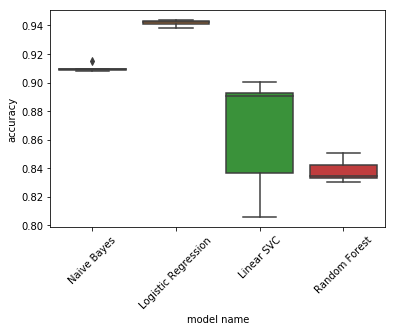

In [28]:
cv_df = pd.DataFrame(algo_results, columns=['model name', 'fold', 'accuracy'])
ax = sns.boxplot(x='model name', y='accuracy', data=cv_df)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

It seems logistic regression results in the best accuracy averaged over the folds. Also the variance of the results in this case is small.

Finally, let's fit the model to the entire train set and evaluate on the main test set:

In [29]:
count_vectorizer, tfidf_transformer, train_features = get_features(train_dataset['string'], nfeatures=5000,
                                                                   feature_selector=select_features_chi2,
                                                                   ngrams=(2, 4))
_, _, test_features = get_features(test_dataset['string'], count_vectorizer=count_vectorizer,
                                   tfidf_transformer=tfidf_transformer)
model = LogisticRegression(random_state=0).fit(train_features, train_dataset['style'])
prediction = model.predict(test_features)
print('The final accuracy: {}'.format(accuracy_score(test_dataset['style'], prediction)))

The final accuracy: 0.9406630184071276


The final unbiased accuracy estimate is 94.1%.